# FIGURE 2

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import MSclusPLSR_tuning
from msresist.plsr import Q2Y_across_components, R2Y_across_components
from msresist.figures.figure2 import plotR2YQ2Y, plotMixedClusteringPLSR_GridSearch, plotMeasuredVsPredicted, plotScoresLoadings, plotclusteraverages
from msresist.clustering import MassSpecClustering
from msresist.sequence_analysis import preprocess_seqs, FormatName, pYmotifs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing, MergeDfbyMean, LinearFoldChange, FoldChangeToControl, MapOverlappingPeptides, BuildMatrix, TripsMeanAndStd, CorrCoefFilter
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

In [2]:
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000)
# pd.set_option('display.max_columns', 1000)

### Importing and Pre-processing Data

### Phosphorylation measurements:

In [3]:
ABC = preprocessing(AXLwt=True, motifs=True, Vfilter=True, FCfilter=True, log2T=True)
ABC = preprocess_seqs(ABC, "Y").sort_values(by="Protein")

header = ABC.columns
treatments = ABC.columns[7:]

data = ABC.iloc[:, 7:].T
info = ABC.iloc[:, :7]

In [4]:
ABC

,Protein,Sequence,UniprotAcc,Abbv,Position,r2_Std,BioReps,PC9,Erl,R428,Erl/R428,Erl+HGF,Erl+FGF,Erl+IGF,KO Erl,KO R428,KO Erl/R428
0,"1-phosphatidylinositol 4,5-bisphosphate phosph...",RNPGFyVEANP,P19174,PLCG1,Y783-p,NA,1,0.891610,-0.132290,0.508638,-0.431225,-0.008149,0.338497,-0.481326,-0.713501,0.547278,-0.519532
3,14-3-3 protein epsilon,GDYHRyLAEFA,P62258,YWHAE,Y131-p,NA,1,0.413272,0.620284,0.352508,-0.291815,0.122734,0.216532,0.167650,-0.586405,-0.395571,-0.619189
4,14-3-3 protein zeta/delta,LLSVAyKNVVG,P63104,YWHAZ,Y48-p,NA,1,2.028584,1.620221,1.301309,-0.568873,-0.712916,-0.731959,-0.791261,-0.762381,-0.574292,-0.808433
13,60S ribosomal protein L15,KAKQGyVIYRI,P61313,RPL15,Y59-p,NA,1,0.092089,0.525990,0.012584,0.583682,0.215550,-0.128648,-0.055638,-0.739524,-0.205843,-0.300242
14,60S ribosomal protein L22-like 1,TYELRyFQISQ,Q6P5R6,RPL22L1,Y108-p,NA,1,-0.050440,-0.157775,-0.042431,0.073614,-0.466527,-0.151340,0.006562,-0.384522,1.342117,-0.169258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,WD repeat-containing protein 1,HDGGIyAISWS,O75083,WDR1,Y238-p,NA,1,-0.199057,0.454706,0.653321,0.118713,0.350850,-0.040757,-0.211529,-0.172431,0.132210,-1.086025
634,Zinc finger CCCH-type antiviral protein 1,LLSSDyRIING,Q7Z2W4,ZC3HAV1,Y410-p,NA,1,2.169358,1.570918,0.620437,-1.374179,0.289226,-0.012489,0.232086,-0.981527,-1.024902,-1.488927
636,Zinc finger protein 185,GALADyEGKDV,O15231,ZNF185,Y408-p,NA,1,1.316789,0.388504,0.263724,-1.455803,0.597152,0.022433,0.432893,-0.449084,-0.012254,-1.104353
637,Zinc finger protein 185,LFVKEyVNASE,O15231,ZNF185,Y581-p,0.96,2,2.694753,0.852521,0.959014,-1.434426,0.582779,-0.266371,-0.040972,-1.194264,-0.760311,-1.392723


### Phenotypes

#### Cell Viability:

In [5]:
Y_cv1 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]
Y_cv2 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw4.csv').iloc[:29, :11]

for ii in range(1, Y_cv2.columns.size):
    Y_cv1.iloc[:, ii] /= Y_cv1.iloc[0, ii]
    Y_cv2.iloc[:, ii] /= Y_cv2.iloc[0, ii]

Y_cv = MergeDfbyMean(pd.concat([Y_cv1, Y_cv2], axis=0), Y_cv1.columns, "Elapsed")
Y_cv = Y_cv.reset_index()[Y_cv1.columns]
Y_cv = Y_cv[Y_cv["Elapsed"] == 72].iloc[0, 1:]

# Chained MS mixed clustering + PLSR analysis

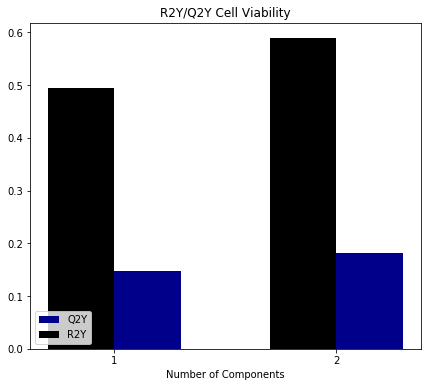

In [6]:
distance_method = "Binomial"
ncl = 2
GMMweight = 0

MSC = MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method=distance_method).fit(data, Y_cv)
centers = MSC.transform(data)

fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotR2YQ2Y(ax, ncl, centers, Y_cv)

In [7]:
# fig, ax = plt.subplots(1, 1, figsize=(8,6))
# plotMixedClusteringPLSR_GridSearch(ax, data, info, Y_cv)

In [8]:
ncomp = 2

mixedCl_plsr = Pipeline([('mixedCl', MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method=distance_method)), ('plsr', PLSRegression(ncomp))])
fit = mixedCl_plsr.fit(data, Y_cv)

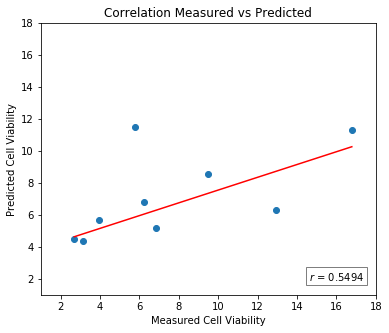

In [9]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plotMeasuredVsPredicted(ax, mixedCl_plsr, data, Y_cv)

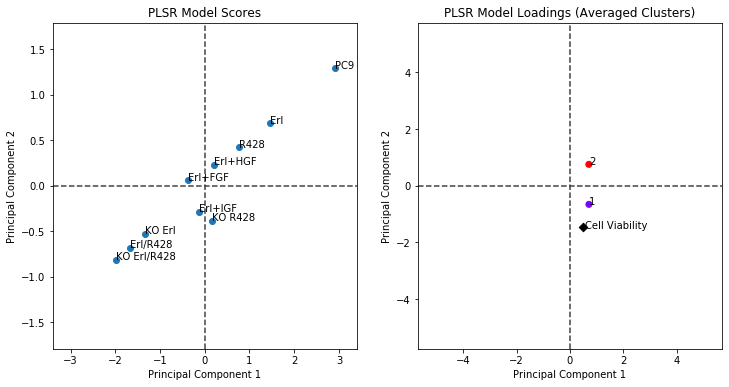

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

plotScoresLoadings(ax, fit, centers, Y_cv, ncl, treatments)

In [11]:
clustermembers = mixedCl_plsr.named_steps.mixedCl.clustermembers(ABC.T)
clustermembers.iloc[:10, :]

,Prot_C1,abbv_C1,seqs_C1,UniprotAcc_C1,Pos_C1,r2/Std_C1,BioReps_C1,Prot_C2,abbv_C2,seqs_C2,UniprotAcc_C2,Pos_C2,r2/Std_C2,BioReps_C2
0,"1-phosphatidylinositol 4,5-bisphosphate phosph...",Y783-p,RNPGFyVEANP,P19174,PLCG1,NA,1,14-3-3 protein epsilon,Y131-p,GDYHRyLAEFA,P62258,YWHAE,NA,1
1,14-3-3 protein zeta/delta,Y48-p,LLSVAyKNVVG,P63104,YWHAZ,NA,1,60S ribosomal protein L22-like 1,Y108-p,TYELRyFQISQ,Q6P5R6,RPL22L1,NA,1
2,60S ribosomal protein L15,Y59-p,KAKQGyVIYRI,P61313,RPL15,NA,1,ADP/ATP translocase 2,Y81-p,ANVIRyFPTQA,P05141,SLC25A5,NA,1
3,ARF GTPase-activating protein GIT1,Y383-p,DDQHDyDSVAS,Q9Y2X7,GIT1,NA,1,ARF GTPase-activating protein GIT1,Y598-p,GADSDyENTQS,Q9Y2X7,GIT1,NA,1
4,Actin filament-associated protein 1-like 2,Y56-p,DEEYIyMNKVT,Q8N4X5,AFAP1L2,NA,1,ATPase WRNIP1,Y500-p,AGEEHyNCISA,Q96S55,WRNIP1,NA,1
5,Actin-related protein 3,Y109-p,EPEDHyFLLTE,P61158,ACTR3,NA,1,Abl interactor 2,Y213-p,VVPNDyVPSPT,Q9NYB9,ABI2,NA,1
6,Activated CDC42 kinase 1,Y827-p,ASDPKyATPQV,Q07912,TNK2,0.67,2,Aldehyde dehydrogenase family 1 member A3,Y437-p,ANSTDyGLTAA,P47895,ALDH1A3,NA,1
7,Activated CDC42 kinase 1,Y859-p,VSSTHyYLLPE,Q07912,TNK2,NA,1,Aldo-keto reductase family 1 member B1,Y40-p,AIDVGyRHIDC,P15121,AKR1B1,NA,1
8,Adapter molecule crk,Y136-p,QEEAEyVRALF,P46108,CRK,0.85,2,Alpha-actinin-1,Y708-p,NKHTNyTMEHI,P12814,ACTN1,NA,1
9,"Adenylate kinase 2, mitochondrial",Y12-p,AAEPEyPKGIR,P54819,AK2,NA,1,Alpha-actinin-4,Y234-p,EVAEKyLDIPK,O43707,ACTN4,NA,1


In [12]:
create_download_link(clustermembers, "DataClustering")

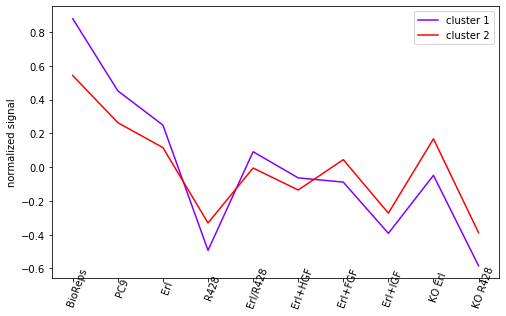

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

plotclusteraverages(ax, ABC, mixedCl_plsr, ncl)